In [2]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from IPython.core.interactiveshell import InteractiveShell

import os
import warnings
import pandas as pd

In [3]:
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [4]:
input_dir = '../Database/'
file = 'train.csv'
data = pd.read_csv(os.path.join(input_dir, file))
data

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [5]:
label_encoder=LabelEncoder()
encoder_data = label_encoder.fit_transform(list(data['대출기간']))
data['대출기간']=pd.DataFrame(encoder_data)

In [6]:
label_encoder=LabelEncoder()
encoder_data = label_encoder.fit_transform(list(data['근로기간']))
data['근로기간']=pd.DataFrame(encoder_data)

In [7]:
label_encoder=LabelEncoder()
encoder_data = label_encoder.fit_transform(list(data['주택소유상태']))
data['주택소유상태']=pd.DataFrame(encoder_data)

In [8]:
label_encoder=LabelEncoder()
encoder_data = label_encoder.fit_transform(list(data['대출목적']))
data['대출목적']=pd.DataFrame(encoder_data)

In [9]:
label_encoder=LabelEncoder()
encoder_data = label_encoder.fit_transform(list(data['대출등급']))
data['대출등급']=pd.DataFrame(encoder_data)

In [10]:
data.set_index(data['ID'], inplace=True)
data.pop('ID')
# data.drop('TRAIN_12498', inplace=True)

ID
TRAIN_00000    TRAIN_00000
TRAIN_00001    TRAIN_00001
TRAIN_00002    TRAIN_00002
TRAIN_00003    TRAIN_00003
TRAIN_00004    TRAIN_00004
                  ...     
TRAIN_96289    TRAIN_96289
TRAIN_96290    TRAIN_96290
TRAIN_96291    TRAIN_96291
TRAIN_96292    TRAIN_96292
TRAIN_96293    TRAIN_96293
Name: ID, Length: 96294, dtype: object

In [11]:
gt = pd.DataFrame(data['대출등급'], columns=['대출등급'])
to_normalize_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
X = pd.DataFrame(data[to_normalize_list], columns=to_normalize_list, index=data.index)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
data_scaled = pd.DataFrame(data_scaled, columns=X.columns, index=data.index)

In [12]:
data.drop(columns=to_normalize_list, inplace=True)
data.pop('대출등급')

train = pd.concat([gt, data_scaled, data], axis=1)

train

ID
TRAIN_00000    2
TRAIN_00001    1
TRAIN_00002    0
TRAIN_00003    2
TRAIN_00004    1
              ..
TRAIN_96289    2
TRAIN_96290    4
TRAIN_96291    0
TRAIN_96292    3
TRAIN_96293    2
Name: 대출등급, Length: 96294, dtype: int64

,대출등급,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출기간,근로기간,주택소유상태,대출목적
ID,,,,,,,,,,,,,,
TRAIN_00000,2,-0.563848,-0.220218,-0.014287,-0.852449,-0.376102,-0.800303,-0.972784,-0.038438,-0.072595,0,9,3,1
TRAIN_00001,1,-0.377964,0.370332,0.087890,-0.356109,-0.376102,-0.436814,-0.441082,-0.038438,-0.072595,1,2,1,10
TRAIN_00002,0,-0.610319,0.020823,-0.321114,-0.935172,-0.376102,0.103276,-0.627621,-0.038438,-0.072595,0,8,1,1
TRAIN_00003,2,-0.377964,0.382384,-0.127783,-0.852449,-0.376102,-0.483274,-0.624977,-0.038438,-0.072595,0,11,1,1
TRAIN_00004,1,-0.029431,-0.222870,0.179044,-0.521556,-0.376102,-0.577932,-0.634409,-0.038438,-0.072595,1,15,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_96289,2,-0.377964,1.165767,-0.299368,0.636570,-0.376102,0.147972,0.145249,-0.038438,-0.072595,0,2,1,3
TRAIN_96290,4,1.016166,0.382384,-0.423588,-0.025216,-0.376102,-0.232331,0.969667,-0.038438,-0.072595,1,2,1,10
TRAIN_96291,0,-0.377964,-0.099698,-0.242471,-0.273386,-0.376102,0.648632,-0.424781,-0.038438,-0.072595,0,0,1,3


In [16]:
plt.rc('font', family='GULIM')

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

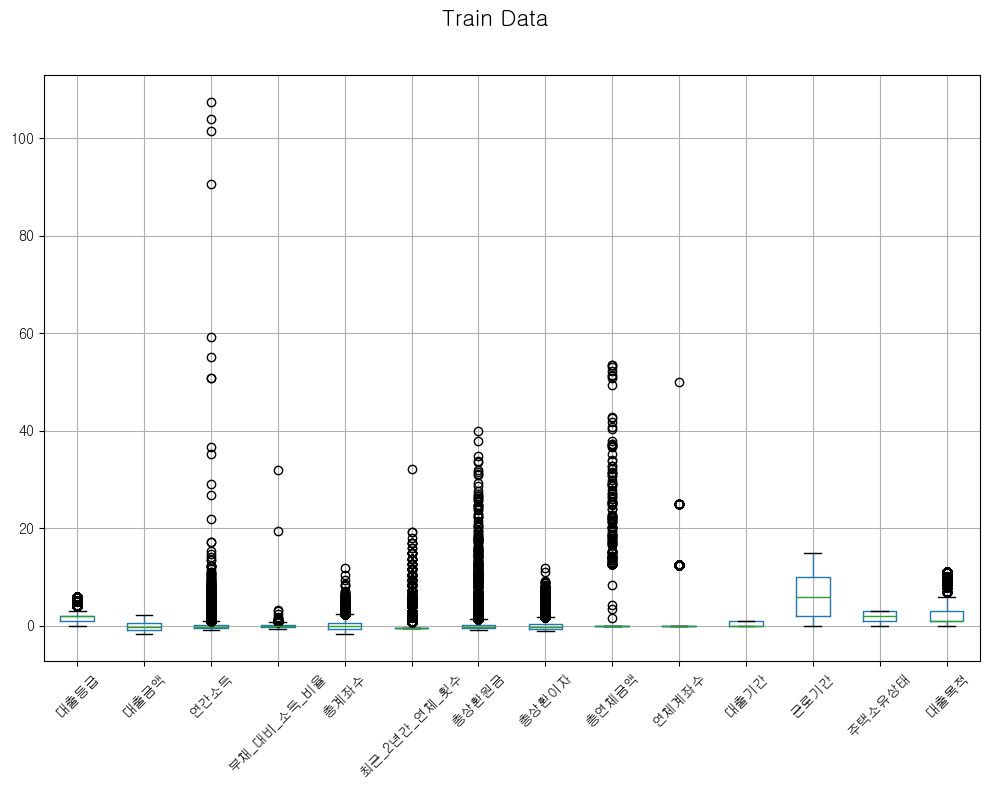

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [22]:
col='총상환원금'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

963

96293

In [23]:
train.drop(outliers_index, inplace=True)

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

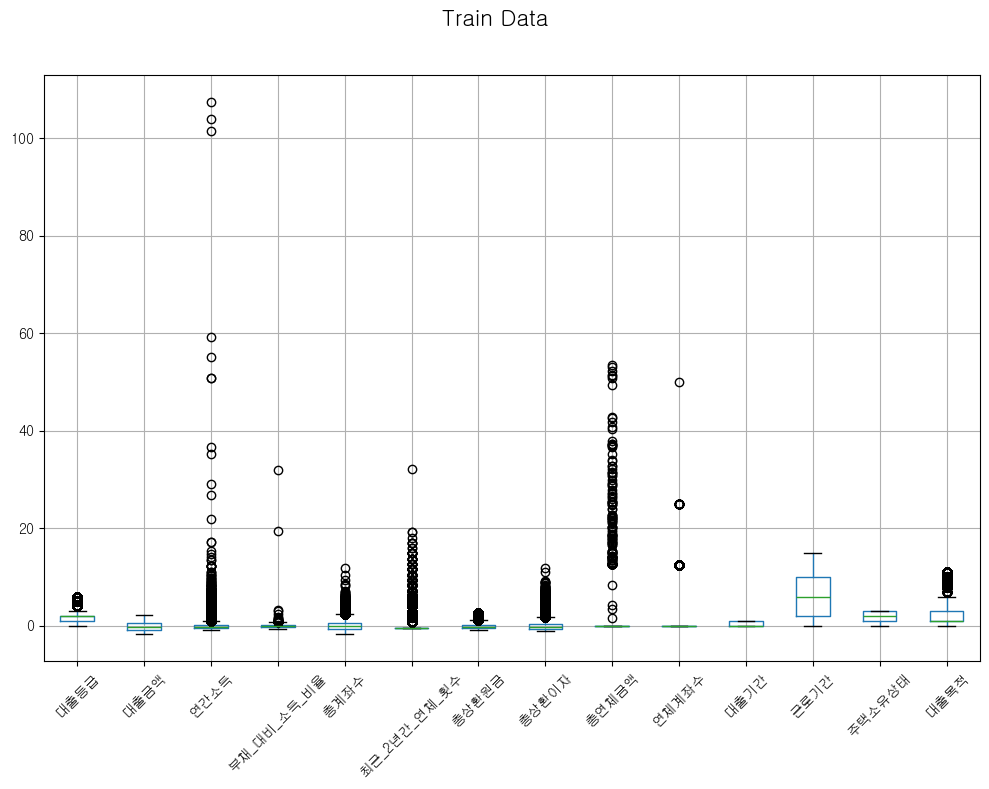

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [25]:
col='연간소득'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

1905

95330

In [26]:
train.drop(outliers_index, inplace=True)

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

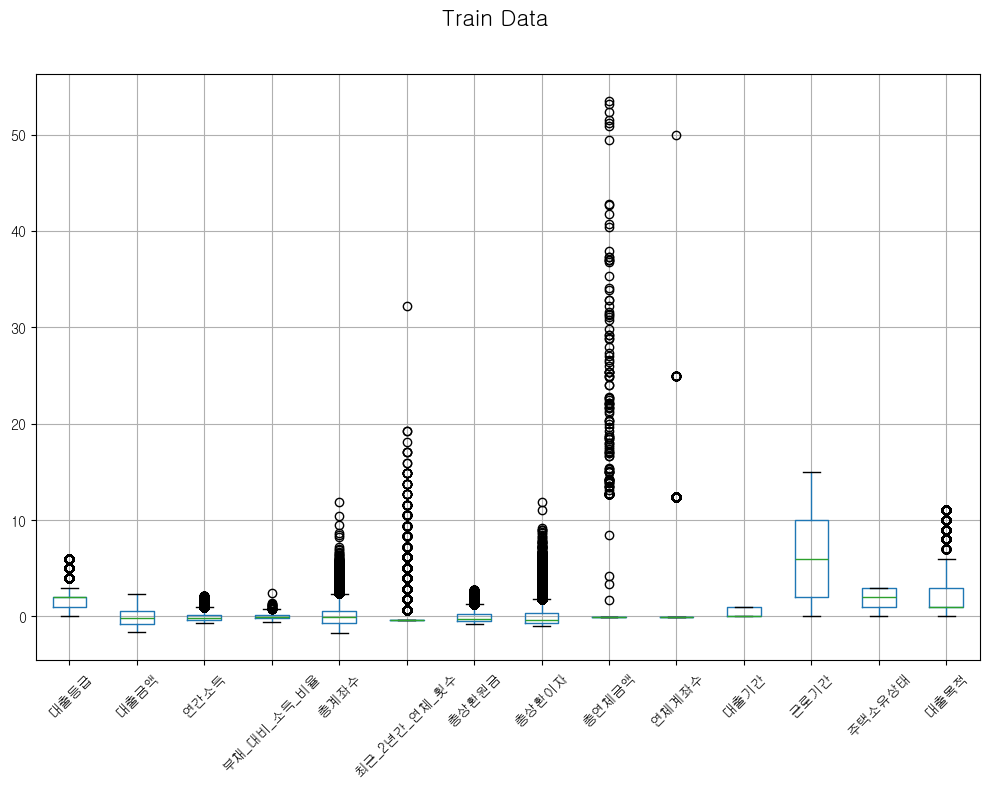

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [28]:
col='총연체금액'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

175

93425

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

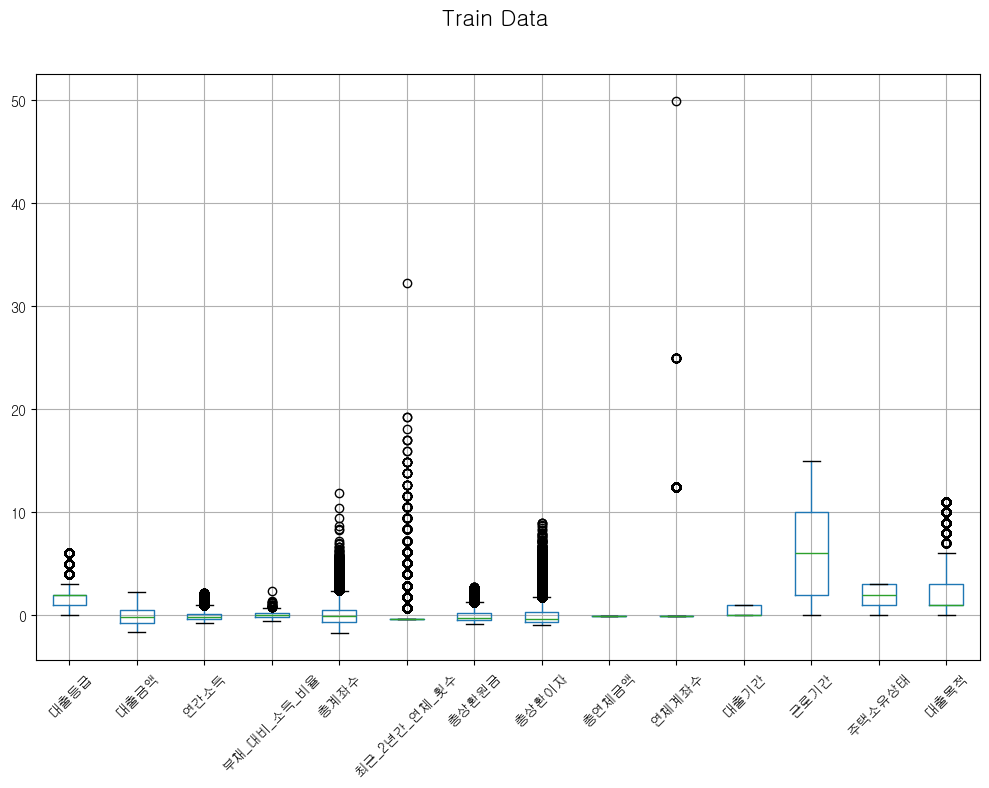

In [29]:
train.drop(outliers_index, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [30]:
col='연체계좌수'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

514

93250

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

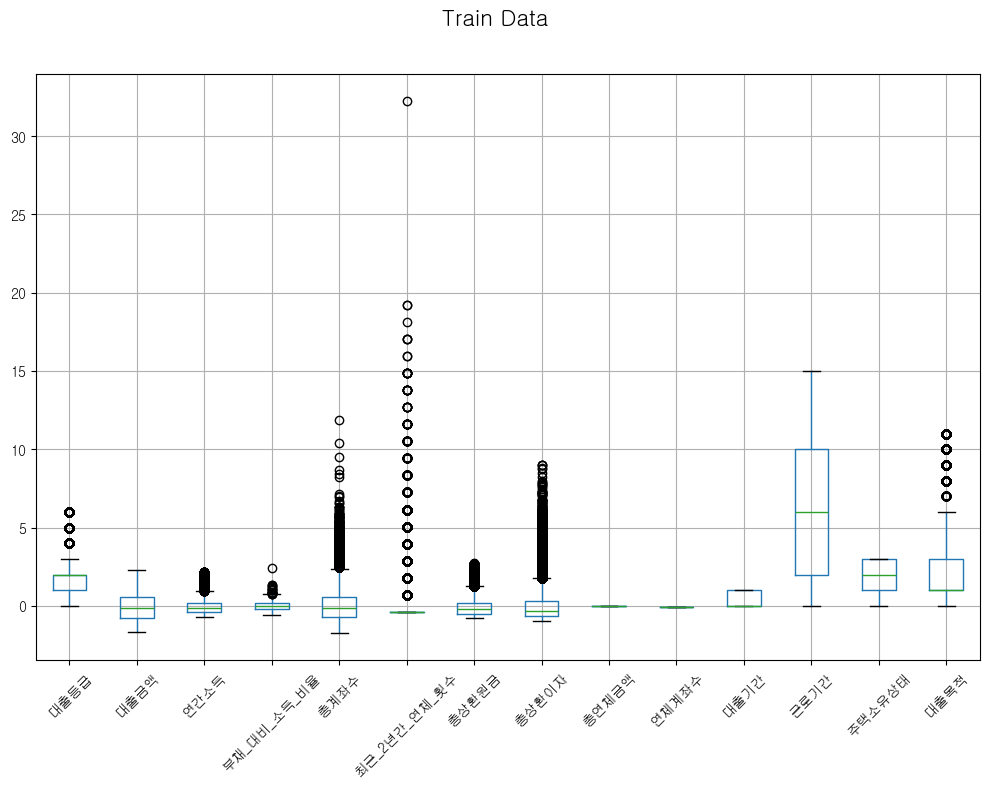

In [31]:
train.drop(outliers_index, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [39]:
col='최근_2년간_연체_횟수'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

750

92736

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

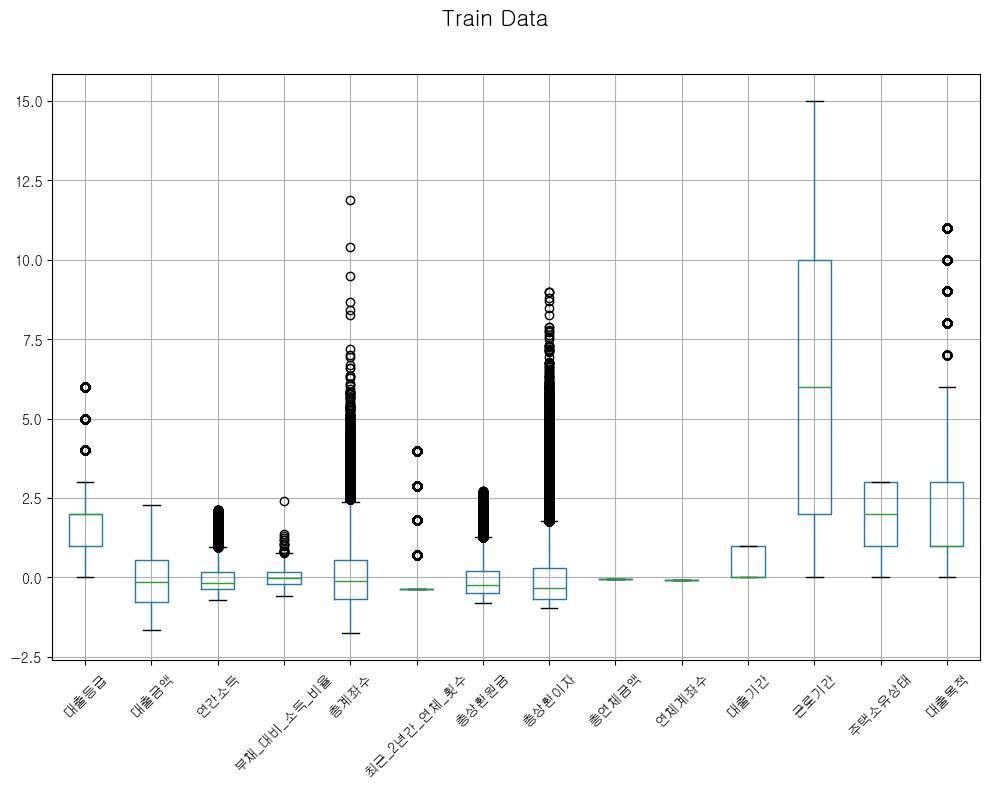

In [40]:
train.drop(outliers_index, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [41]:
col='총상환이자'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

920

91986

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

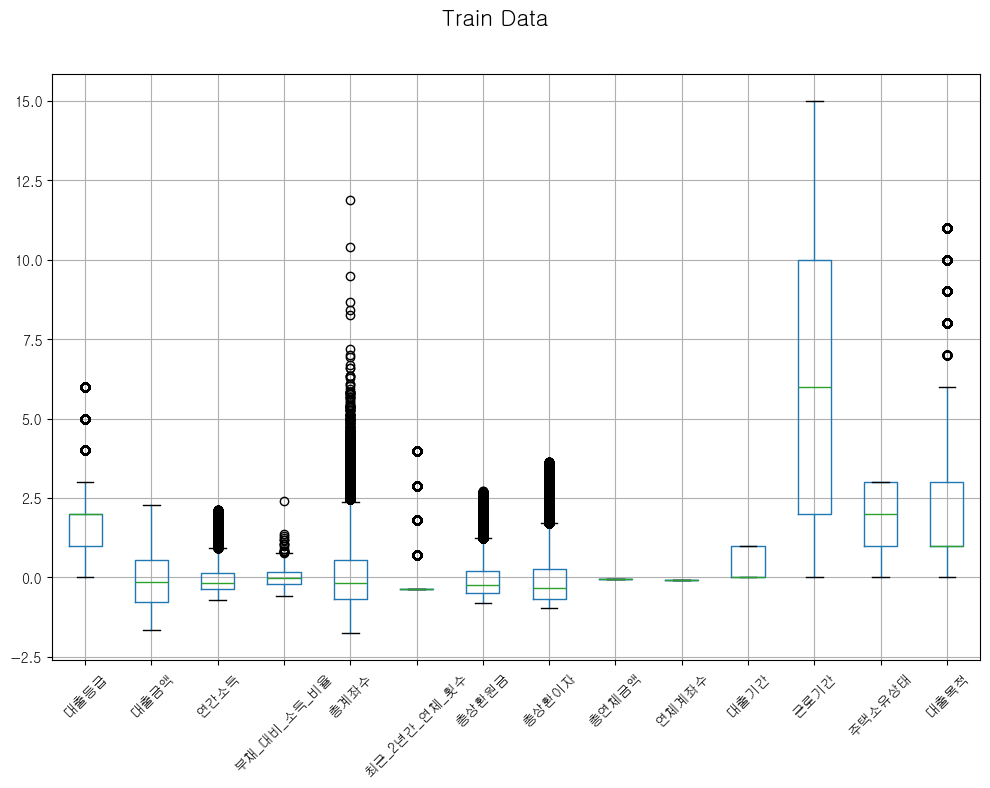

In [42]:
train.drop(outliers_index, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [43]:
col='총계좌수'

Q1 = train[col].quantile(0.99)
Q3 = train[col].quantile(0.01)
outliers_index = train[(train[col] > Q1) | (train[col] < Q3)].index
len(outliers_index)
len(train)

1658

91066

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

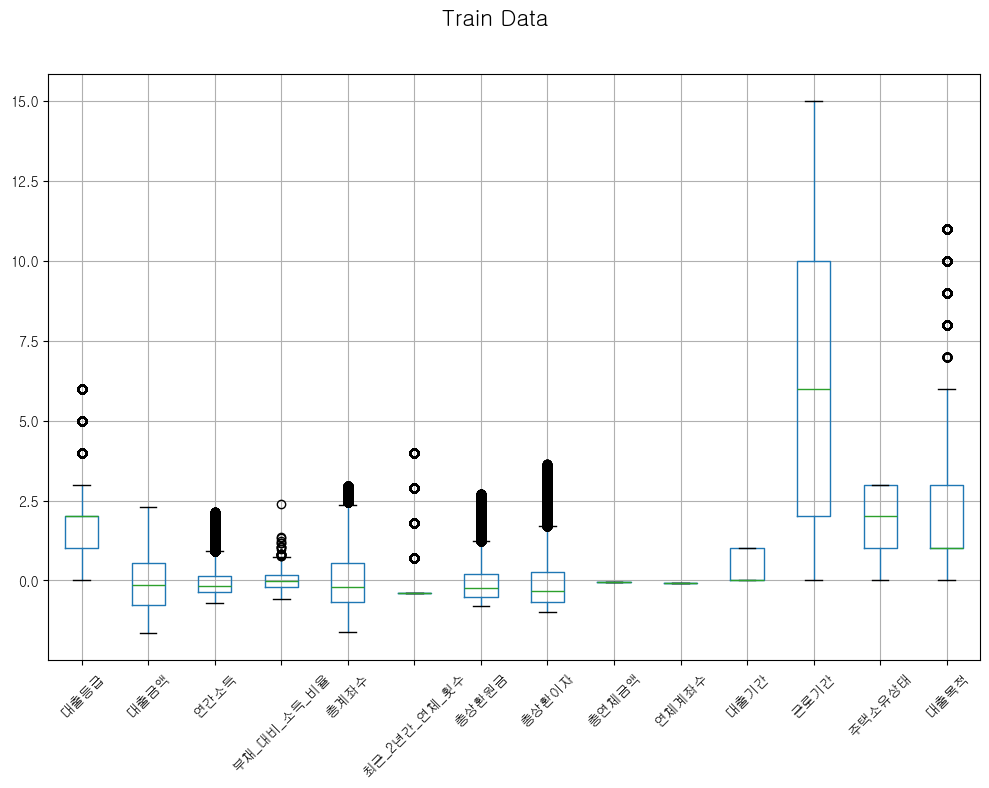

In [44]:
train.drop(outliers_index, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [45]:
train.to_csv('../Database/train_modified3.csv')